## Quantifying day ahead gaps in prices per year

In [468]:
import csv
import pandas as pd
import os

import numpy as np 
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator


In [545]:
# Importing data
dir = '../20_data/entsoe_data/DE/DA_60min/DE-LU/'
df = pd.DataFrame()
for i in os.listdir(dir):
    df_int = pd.read_csv(dir + i)
    df_int = df_int.drop(columns=[df_int.columns[2],df_int.columns[3]])#.set_index('MTU (CET/CEST)')
    df_int['MTU (CET/CEST)'] = df_int['MTU (CET/CEST)'].apply(lambda x: x[0:16])
    df_int = df_int.drop(df_int[df_int['Day-ahead Price [EUR/MWh]'] == 'n/e'].index).dropna().set_index('MTU (CET/CEST)')
    df_int = df_int.astype({'Day-ahead Price [EUR/MWh]': 'float'})
    df_int.index = pd.to_datetime(df_int.index, format = "%d.%m.%Y %H:%M")
    df = pd.concat([df,df_int])
    #print(df_int)
df.sort_index(inplace=True)
df_D = pd.DataFrame()
df_D['spread'] = (df.resample('d').max()- df.resample('d').min())
df_D['mean'] = (df.resample('d').mean())
df_D['min'] = (df.resample('d').min())
df_D['max'] = (df.resample('d').max())

## TOD maximizing policy (all years combined)

In [546]:
print('Buy at: ' + str(df.groupby(df.index.hour)['Day-ahead Price [EUR/MWh]'].mean().idxmin()) + ':00')
print('Sell at: ' + str(df.groupby(df.index.hour)['Day-ahead Price [EUR/MWh]'].mean().idxmax()) + ':00')
print('Average spread: ' + str(round(df.groupby(df.index.hour)['Day-ahead Price [EUR/MWh]'].mean().max()-df.groupby(df.index.hour)['Day-ahead Price [EUR/MWh]'].mean().min(),2)))

Buy at: 3:00
Sell at: 19:00
Average spread: 54.52


## TOD maximizing policy (monthly evolution)

<Axes: title={'center': 'Time of monthly avg min and max day-ahead prices'}, xlabel='year,month'>

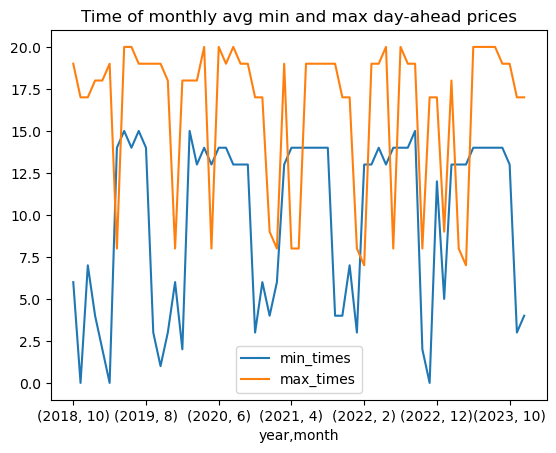

In [547]:
# Setting up monthly dataframe
df_m = df.copy()
df_m['year'] = df_m.index.year
df_m['month'] = df_m.index.month
df_m['hour'] = df_m.index.hour
df_m = df_m.reset_index().set_index(['year','month','hour']) # Multi-indexed dataframe (year-month hour average)

# Times of maximum average prices
max_times = df_m.groupby(level=[0,1])['Day-ahead Price [EUR/MWh]'].idxmax().to_list()
max_times = list(map(lambda max_times:max_times[2],max_times))

# Times of minimum average prices
min_times = df_m.groupby(level=[0,1])['Day-ahead Price [EUR/MWh]'].idxmin().to_list()
min_times = list(map(lambda min_times:min_times[2],min_times))


# Plotting 
pd.DataFrame({'min_times' : min_times, 'max_times' : max_times}, index = df_m.groupby(level=[0,1]).max().index).plot(title='Time of monthly avg min and max day-ahead prices')

## Average time of day with min and max day ahead prices

[Text(0.5, 23.52222222222222, 'Start of one hour period [TOD]'),
 Text(50.722222222222214, 0.5, 'Month [YYYY-MM]'),
 Text(0.5, 1.0, 'Average normalized monthly day ahead price at TOD')]

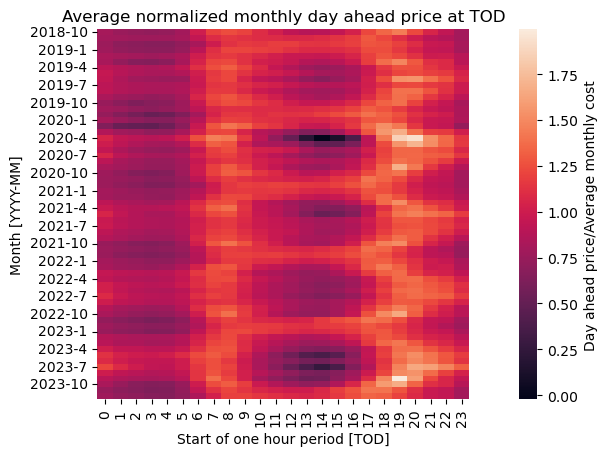

In [548]:
df_m_h = df_m.copy()
df_m_h.drop(columns=['MTU (CET/CEST)'], inplace=True)
df_m_h.reset_index(inplace=True)
df_m_h['month'] = df_m_h['year'].astype(str) + '-' + df_m_h['month'].astype(str)
df_m_h = df_m_h.drop(columns = ['year']).set_index('month')

df_m_h['weights'] = df_m_h.groupby(by=['month']).mean()['Day-ahead Price [EUR/MWh]']
df_m_h = df_m_h.groupby(by=['month','hour']).mean().reset_index()

df_m_h['Day-ahead Price [EUR/MWh]'] = df_m_h['Day-ahead Price [EUR/MWh]']/df_m_h['weights']

df_m_h.month = pd.to_datetime(df_m_h.month)
df_m_h.sort_values(by='month', inplace=True)
df_m_h.reset_index(inplace=True)
df_m_h = df_m_h.pivot(index = 'month', columns='hour', values='Day-ahead Price [EUR/MWh]')
df_m_h.index = df_m_h.index.year.astype(str) + '-' + df_m_h.index.month.astype(str)
df_m_h

ax = sns.heatmap(df_m_h, annot=False, cbar_kws={'label': 'Day ahead price/Average monthly cost','pad': 0.1})#,norm=LogNorm())
ax.set(xlabel='Start of one hour period [TOD]', ylabel='Month [YYYY-MM]', title='Average normalized monthly day ahead price at TOD')